<a href="https://colab.research.google.com/github/PeterDeWeirdt/rs_dev/blob/main/code/04_build_cnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Sequence Model

Before running this model, be sure to copy activity data, train_data_names.csv, core.py, datasets_colab.py

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 19 20:48:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import multiprocessing
n_cpus = multiprocessing.cpu_count()
print(n_cpus)

4


In [3]:
!pip install -U --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.9MB 1.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 296kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 47.8MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 143kB 66.9MB/s 
     |████████████████████████████████| 112kB 56.5MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for alembic: filename=alembic-1.6.2-py2.py3-none-any.whl size=164219 sha256=cef85097804c3da5a51c8ee599e686c406d28a5ac3d47ca80210387503582159
  Stored in directory: /root/.cache/pip/wheels/a5/63/44/db29401e49ef5331c163b591f12a465c40af864bfa888dabd2
  Created wheel for pyperclip: filena

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
import optuna
from joblib import Parallel, delayed
import numpy as np
from tensorflow import keras
from datetime import datetime

from datasets_colab import dataset_list
from core import (get_predictive_performance,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  setup_plots)

In [5]:
setup_plots()

In [6]:
train_data_names = pd.read_csv('train_data_names.csv').name.to_list()

In [7]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

## Cross-Validation Iterator

In [8]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [9]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10604
1,1,True,Kim2019_train,10574
2,4,True,Kim2019_train,10354
3,0,True,Kim2019_train,10267
4,2,True,Kim2019_train,9529
5,2,False,Kim2019_train,3303
6,0,False,Kim2019_train,2565
7,4,False,Kim2019_train,2478
8,1,True,Doench2016,2319
9,1,False,Kim2019_train,2258


## Keras Convolutional Neural Network

In [10]:
def get_cnn(n_conv_layers, filters_per_conv, filter_len,
            nodes_per_dense, dense_dropout_rate, n_dense_layers=1,
            input_shape=(30, 4), activation='relu', initializer='he_uniform',
            pool_size=2, loss='mse', optimizer='Adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for _ in range(n_conv_layers):
        model.add(keras.layers.Conv1D(filters=filters_per_conv, kernel_size=filter_len,
                                      activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.AveragePooling1D(pool_size=pool_size))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(dense_dropout_rate))
    for _ in range(n_dense_layers):
        model.add(keras.layers.Dense(nodes_per_dense, activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(dense_dropout_rate))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

nt_codes = {'A':[1,0,0,0],
            'C':[0,1,0,0],
            'G':[0,0,1,0],
            'T':[0,0,0,1]}

def encode_seqs(seqs):
    # 3d array with samples x position x nt
    encoded_seqs = np.array([[nt_codes.get(x) for x in seq] for seq in seqs])
    return encoded_seqs


def cnn_training_iteration(fold_df, train_index, test_index, base_model):
    """Train cnn model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: KerasRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = clone(base_model)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = encode_seqs(test_df['sgRNA Context Sequence'])
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_cnn_objective(fold_df):
    """Get objective function for training a cnn model

    :param fold_df: DataFrame
    :return: objective function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for cnn

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        n_conv_layers = trial.suggest_int('n_conv_layers', 1, 2)
        filters_per_conv = trial.suggest_int('filters_per_conv', 32, 256)
        filter_len = trial.suggest_int('filter_len', 2, 8)
        nodes_per_dense = trial.suggest_int('nodes_per_dense', 8, 256)
        dense_dropout_rate = trial.suggest_float('dense_dropout_rate', 0.1, 0.5)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                           n_conv_layers=n_conv_layers,
                                                           filters_per_conv=filters_per_conv,
                                                           filter_len=filter_len,
                                                           nodes_per_dense=nodes_per_dense,
                                                           dense_dropout_rate=dense_dropout_rate)
        performance = Parallel(n_jobs=5)(delayed(cnn_training_iteration)
                                         (fold_df, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [11]:
n_trials = 50
cnn_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_cnn_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    train_val_seqs = train_df['sgRNA Context Sequence'] # train and validation data
    y_train_val = train_df['sgRNA Activity']
    train_seqs, val_seqs, y_train, y_val = train_test_split(train_val_seqs, y_train_val,
                                                            test_size=0.1, random_state=7)
    X_train = encode_seqs(train_seqs)
    X_val = encode_seqs(val_seqs)
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_cnn, epochs=5000,
                                                       **trial.params)
    model.fit(X_train, y_train, verbose=0, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=20)])
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = encode_seqs(fold_test_data['sgRNA Context Sequence'])
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All + CNN + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    cnn_prediction_list.append(test_predictions)

[I 2021-05-19 20:49:00,664] A new study created in memory with name: no-name-1a227504-9cb1-495e-98ac-4f07263870f8


Fold: 0


[I 2021-05-19 20:51:44,405] Trial 0 finished with value: 0.4511748453401797 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.4511748453401797.
[I 2021-05-19 20:53:40,410] Trial 1 finished with value: 0.4097456189295646 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.4511748453401797.
[I 2021-05-19 20:55:21,592] Trial 2 finished with value: 0.4071059060659382 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.4511748453401797.
[I 2021-05-19 20:56:30,365] Trial 3 finished with value: 0.36420603925016815 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dropou

Number of finished trials: 50
Training Time: 1:42:48.982380
Best trial:
  Value: 0.46200341621708124
  Params: 
    n_conv_layers: 1
    filters_per_conv: 129
    filter_len: 7
    nodes_per_dense: 37
    dense_dropout_rate: 0.444392813721114


[I 2021-05-19 22:32:31,333] A new study created in memory with name: no-name-515de7b6-3937-4bed-99df-582d8d39532a


Fold: 1


[I 2021-05-19 22:34:32,961] Trial 0 finished with value: 0.44307186872868753 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.44307186872868753.
[I 2021-05-19 22:36:44,645] Trial 1 finished with value: 0.40055727442729105 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.44307186872868753.
[I 2021-05-19 22:38:23,437] Trial 2 finished with value: 0.4089645989930948 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.44307186872868753.
[I 2021-05-19 22:39:37,168] Trial 3 finished with value: 0.35650789719485865 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_d

Number of finished trials: 50
Training Time: 1:38:30.043907
Best trial:
  Value: 0.44580571336932556
  Params: 
    n_conv_layers: 1
    filters_per_conv: 243
    filter_len: 5
    nodes_per_dense: 182
    dense_dropout_rate: 0.498718871204515


[I 2021-05-20 00:11:51,339] A new study created in memory with name: no-name-d550e325-bd5f-474c-9ab4-af8b83b7b373


Fold: 2


[I 2021-05-20 00:13:52,870] Trial 0 finished with value: 0.4519784248788839 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.4519784248788839.
[I 2021-05-20 00:15:36,233] Trial 1 finished with value: 0.4107145432566126 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.4519784248788839.
[I 2021-05-20 00:17:07,441] Trial 2 finished with value: 0.4097976554067543 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.4519784248788839.
[I 2021-05-20 00:18:09,533] Trial 3 finished with value: 0.36646195901254874 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dropou

Number of finished trials: 50
Training Time: 1:28:17.558365
Best trial:
  Value: 0.4561893382165351
  Params: 
    n_conv_layers: 1
    filters_per_conv: 167
    filter_len: 5
    nodes_per_dense: 41
    dense_dropout_rate: 0.37129807382902014


[I 2021-05-20 01:40:57,550] A new study created in memory with name: no-name-c0ac47e9-1765-4ff8-8df0-1cb6d0a9f66e


Fold: 3


[I 2021-05-20 01:43:06,531] Trial 0 finished with value: 0.4405883329958827 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.4405883329958827.
[I 2021-05-20 01:45:07,080] Trial 1 finished with value: 0.39666601205452234 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.4405883329958827.
[I 2021-05-20 01:46:54,455] Trial 2 finished with value: 0.40176957465328017 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.4405883329958827.
[I 2021-05-20 01:48:04,926] Trial 3 finished with value: 0.3505169712606507 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_dropo

Number of finished trials: 50
Training Time: 1:35:34.373888
Best trial:
  Value: 0.44732211276137923
  Params: 
    n_conv_layers: 1
    filters_per_conv: 213
    filter_len: 5
    nodes_per_dense: 136
    dense_dropout_rate: 0.3444150199020295


[I 2021-05-20 03:17:17,878] A new study created in memory with name: no-name-3cf8662f-542f-4103-90da-d4da0b797c5c


Fold: 4


[I 2021-05-20 03:19:51,574] Trial 0 finished with value: 0.43343900927258766 and parameters: {'n_conv_layers': 1, 'filters_per_conv': 207, 'filter_len': 5, 'nodes_per_dense': 188, 'dense_dropout_rate': 0.4911958047986411}. Best is trial 0 with value: 0.43343900927258766.
[I 2021-05-20 03:22:01,874] Trial 1 finished with value: 0.40440051366741486 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 144, 'filter_len': 2, 'nodes_per_dense': 74, 'dense_dropout_rate': 0.299953000330224}. Best is trial 0 with value: 0.43343900927258766.
[I 2021-05-20 03:23:40,368] Trial 2 finished with value: 0.40272869001400907 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 212, 'filter_len': 4, 'nodes_per_dense': 24, 'dense_dropout_rate': 0.21525823972319744}. Best is trial 0 with value: 0.43343900927258766.
[I 2021-05-20 03:24:55,007] Trial 3 finished with value: 0.3667933313269261 and parameters: {'n_conv_layers': 2, 'filters_per_conv': 80, 'filter_len': 5, 'nodes_per_dense': 239, 'dense_d

Number of finished trials: 50
Training Time: 1:30:00.675664
Best trial:
  Value: 0.44183686726538235
  Params: 
    n_conv_layers: 1
    filters_per_conv: 254
    filter_len: 7
    nodes_per_dense: 226
    dense_dropout_rate: 0.44068369774892036


In [12]:
cnn_predictive_performance, cnn_agg_performance = get_predictive_performance(cnn_prediction_list,
                                                                             'sgRNA Activity')

In [13]:
cnn_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All + CNN + TPE50,0.56999,0.118902,0.557307


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


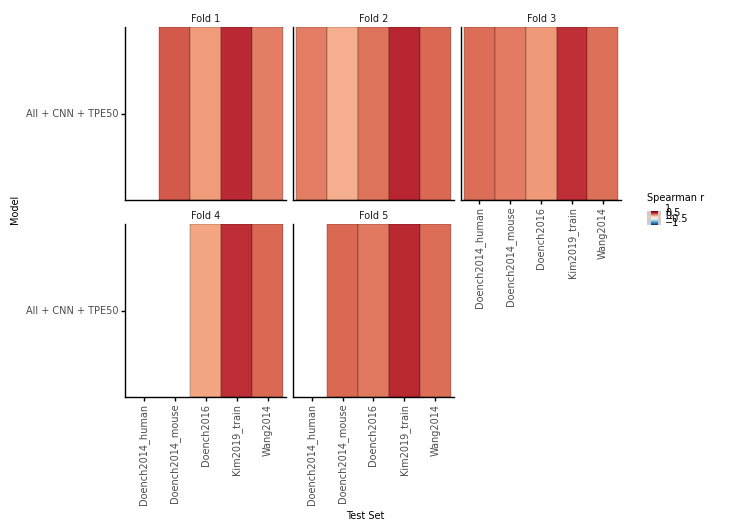

<ggplot: (8777177026393)>

In [14]:
plot_spearman_heatmap(cnn_predictive_performance)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



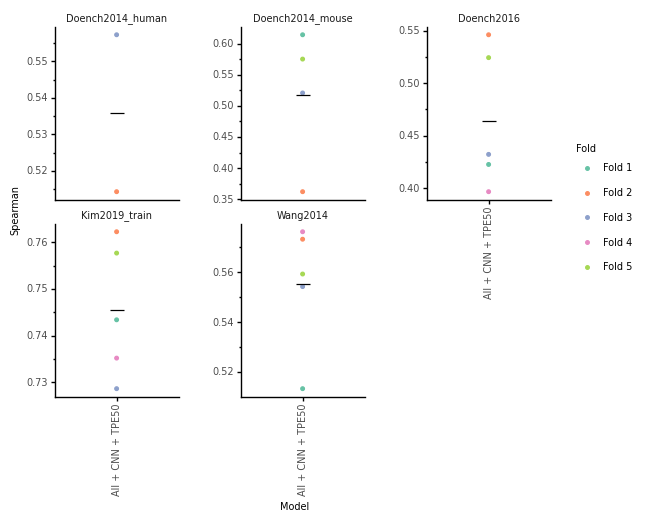

<ggplot: (8777176938065)>

In [15]:
plot_model_performance(cnn_predictive_performance, wspace=0.5)

## **Remember to download the predictive performance dataframe, as the local store is not permanent**


In [16]:
cnn_predictive_performance

,model_name,testing_set,fold,spearman_r,n_guides,fold_name
0,All + CNN + TPE50,Doench2014_human,1,0.514254,167,Fold 2
1,All + CNN + TPE50,Doench2014_human,2,0.557307,828,Fold 3
2,All + CNN + TPE50,Doench2014_mouse,0,0.614397,354,Fold 1
3,All + CNN + TPE50,Doench2014_mouse,1,0.361987,212,Fold 2
4,All + CNN + TPE50,Doench2014_mouse,2,0.520774,85,Fold 3
5,All + CNN + TPE50,Doench2014_mouse,4,0.575284,518,Fold 5
6,All + CNN + TPE50,Doench2016,0,0.422538,732,Fold 1
7,All + CNN + TPE50,Doench2016,1,0.546333,217,Fold 2
8,All + CNN + TPE50,Doench2016,2,0.432160,918,Fold 3
9,All + CNN + TPE50,Doench2016,3,0.396546,327,Fold 4


In [17]:
cnn_predictions = pd.concat(cnn_prediction_list)

In [18]:
cnn_predictions.to_csv('seq_cnn_predictions.csv', index=False)